# Stellar mass profiles based on sg_fluxtable
Preliminary stellar mass profiles of the HST sample based on the radial aperture photometry sg_fluxtable_nm.txt generated in July 2017 at Bates.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import fitsio
import astropy.units as u
from astropy.io import ascii
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
mpl.rcParams.update({'font.size': 18})
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

### Read the original photometry, the fitting results, and the K-corrections.

In [4]:
massdir = os.path.join( os.getenv('HIZEA_PROJECT'), 'massprofiles', 'isedfit' )
etcdir = os.path.join( os.getenv('HIZEA_DIR'), 'etc' )

In [5]:
photfile = os.path.join(etcdir, 'sg_fluxtable_nm.txt')
isedfile = os.path.join(massdir, 'massprofiles_fsps_v2.4_miles_chab_charlot_sfhgrid01.fits.gz')
kcorrfile = os.path.join(massdir, 'massprofiles_fsps_v2.4_miles_chab_charlot_sfhgrid01_kcorr.z0.0.fits.gz')

In [6]:
print('Reading {}'.format(photfile))
phot = ascii.read(photfile)
phot[:2]

Reading /Users/ioannis/repos/hizea/etc/sg_fluxtable_nm.txt


ID,f_475,ivar_475,f_814,ivar_814,f_1600,ivar_1600,z
str8,float64,float64,float64,float64,float64,float64,float64
J0826_00,2.50851809275,63.5660925468,3.12576619129,40.9399221393,1.66482813428,144.31822486,0.603
J0826_01,5.43655673872,13.5335627674,7.21914291268,7.67518253077,4.26729336625,21.9662028651,0.603


In [7]:
print('Reading {}'.format(isedfile))
ised = Table(fitsio.read(isedfile, ext=1, upper=True))
ised[:2]

Reading /Users/ioannis/research/projects/hizea/massprofiles/isedfit/massprofiles_fsps_v2.4_miles_chab_charlot_sfhgrid01.fits.gz


ISEDFIT_ID,RA,DEC,Z,MAGGIES [4],IVARMAGGIES [4],BESTMAGGIES [4],CHUNKINDX,MODELINDX,DELAYED,BURSTTYPE,CHI2,TOTALMASS,TOTALMASS_ERR,MSTAR,AGE,SFRAGE,TAU,ZMETAL,AV,MU,OIIIHB,NLYC,SFR,SFR100,B100,B1000,EWOII,EWOIIIHB,EWNIIHA,NBURST,TRUNCTAU,TBURST,DTBURST,FBURST,MSTAR_50,AGE_50,SFRAGE_50,TAU_50,ZMETAL_50,AV_50,MU_50,OIIIHB_50,SFR_50,SFR100_50,B100_50,B1000_50,EWOII_50,EWOIIIHB_50,EWNIIHA_50,MSTAR_AVG,AGE_AVG,SFRAGE_AVG,TAU_AVG,ZMETAL_AVG,AV_AVG,MU_AVG,OIIIHB_AVG,SFR_AVG,SFR100_AVG,B100_AVG,B1000_AVG,EWOII_AVG,EWOIIIHB_AVG,EWNIIHA_AVG,MSTAR_ERR,AGE_ERR,SFRAGE_ERR,TAU_ERR,ZMETAL_ERR,AV_ERR,MU_ERR,OIIIHB_ERR,SFR_ERR,SFR100_ERR,B100_ERR,B1000_ERR,EWOII_ERR,EWOIIIHB_ERR,EWNIIHA_ERR
int32,float64,float64,float32,float32,float32,float32,int16,int16,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,239.54682546,39.95578122,0.402,0.0 .. 1.67473e-09,0.0 .. 1.42617e+20,2.01102e-09 .. 2.04697e-09,3,1240,0,1,20.4017,3.9705e+08,1.16618e+07,8.4724,5.58126,0.994325,5.47726,0.0278593,0.125096,0.357175,-0.998367,53.7931,0.698053,0.437366,1.58525,0.613275,22.1424,83.0176,670.948,1,0.0243129,5.57973,0.0397391,4.45892,8.47719,5.58126,0.994325,5.47726,0.0278593,0.125096,0.357175,-0.998367,0.702849,0.442162,1.58525,0.613275,22.1424,83.0176,670.948,8.48622,5.60581,1.02347,5.55007,0.0274193,0.130181,0.363263,-0.987775,0.700458,0.442937,1.57767,0.610529,22.9983,82.6027,665.778,0.0951288,0.258762,0.307291,0.767657,0.00463946,0.0536153,0.0641897,0.111678,0.0252036,0.0081749,0.0799569,0.0289529,9.02408,4.37438,54.5064
1,239.54682546,39.95578122,0.402,0.0 .. 4.25669e-09,0.0 .. 2.20758e+19,4.48658e-09 .. 4.56677e-09,3,1240,0,1,2.17153,8.85814e+08,2.56177e+07,8.8209,5.58126,0.994325,5.47726,0.0278593,0.125096,0.357175,-0.998367,54.1416,1.04655,0.785864,1.58525,0.613275,22.1424,83.0176,670.948,1,0.0243129,5.57973,0.0397391,4.45892,8.8269,5.58126,0.994325,5.47726,0.0278593,0.125096,0.357175,-0.998367,1.05255,0.791864,1.58525,0.613275,22.1424,83.0176,670.948,8.91838,5.82768,1.28773,6.20913,0.0234288,0.176298,0.418449,-0.891441,1.02902,0.800231,1.50875,0.585524,30.766,78.8688,618.829,0.0957301,0.258762,0.307291,0.767657,0.00463946,0.0536153,0.0641897,0.111678,0.0246023,0.00877619,0.0799569,0.0289529,9.02408,4.37438,54.5064


In [8]:
print('Reading {}'.format(kcorrfile))
kcorr = Table(fitsio.read(kcorrfile, ext=1, upper=True))
kcorr[:2]

Reading /Users/ioannis/research/projects/hizea/massprofiles/isedfit/massprofiles_fsps_v2.4_miles_chab_charlot_sfhgrid01_kcorr.z0.0.fits.gz


ISEDFIT_ID,Z,MAGGIES [4],IVARMAGGIES [4],CHI2,FLAM_1500,CFLUX_3727,KCORRECT [5],ABSMAG [5],IVARABSMAG [5],SYNTH_ABSMAG [5],ABSMAG_FILTERLIST [5]
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes13
0,0.402,0.0 .. 1.67473e-09,0.0 .. 1.42617e+20,20.4017,6.68999e-17,1.00071e-17,-0.362645 .. -0.549211,-19.7825 .. -19.6787,339.322 .. 339.322,-19.5848 .. -19.4908,bessell_U.par .. bessell_I.par
1,0.402,0.0 .. 4.25669e-09,0.0 .. 2.20758e+19,2.17153,1.49286e-16,2.23306e-17,-0.362646 .. -0.549209,-20.4676 .. -20.4461,339.322 .. 339.321,-20.4563 .. -20.3623,bessell_U.par .. bessell_I.par


In [9]:
galaxy = [gg[:5] for gg in phot['ID'].data]
galaxy = np.unique(galaxy)
ngal = len(galaxy)

### Plot the individual stellar mass profiles.
Fluxes were measured in circular apertures with radii ranging from 1-40 pixels (0.05-2 arcsec).  Below we calculate the surface mass density in units of Mstar per comoving kpc2.

In [10]:
nrad = 40
radpix = np.linspace(1.0, 40.0, nrad) # [pixels]
radarcsec = radpix * 0.05             # [arcsec]

In [11]:
mstar = ised['MSTAR_AVG'].data.reshape(ngal, nrad)
mstar_err = ised['MSTAR_ERR'].data.reshape(ngal, nrad)
redshift = phot['z'].data.reshape(ngal, nrad)[:, 0]

In [12]:
area = np.pi * np.insert(np.diff(radarcsec**2), 0, radarcsec[0]**2) # aperture annulus [arcsec2]

In [13]:
sigma = np.zeros_like(mstar)  # surface mass density [Mstar/kpc2]
radkpc = np.zeros_like(mstar) # radius [comoving kpc]

In [14]:
for igal in range(ngal):
    arcsec2kpc = cosmo.arcsec_per_kpc_comoving(redshift[igal]).value
    radkpc[igal, :] = radarcsec / arcsec2kpc
    areakpc2 = area / arcsec2kpc**2
    sigma[igal, :] = np.log10( 10**mstar[igal, :] / areakpc2 )

In [15]:
massrange = (8, 10.2)
sigmarange = (6, 9.6)

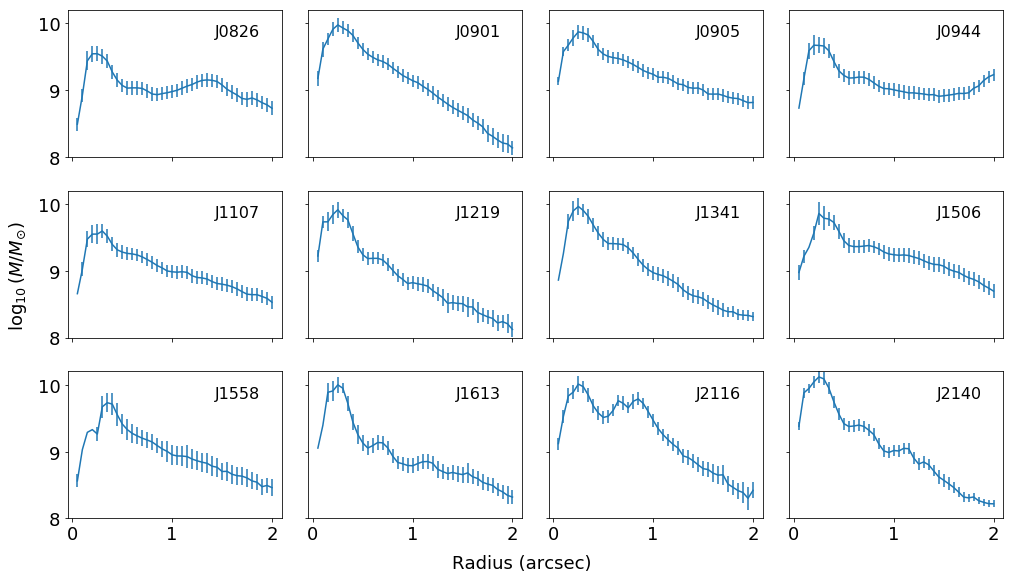

In [16]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8), sharey=True, sharex=True)
for ii, thisax in enumerate(ax.flat):
    thisax.errorbar(radarcsec, mstar[ii, :], yerr=mstar_err[ii, :], 
                    label=galaxy[ii])
    thisax.set_ylim(massrange)
    #thisax.legend(loc='upper right', frameon=False)  
    thisax.annotate(galaxy[ii], xy=(0.9, 0.9), xycoords='axes fraction', 
                    size=16, ha='right', va='top')
fig.text(0.0, 0.5, r'$\log_{10}\, (M / M_{\odot})$', ha='center', 
         va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Radius (arcsec)', ha='center', 
         va='center')
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.tight_layout()

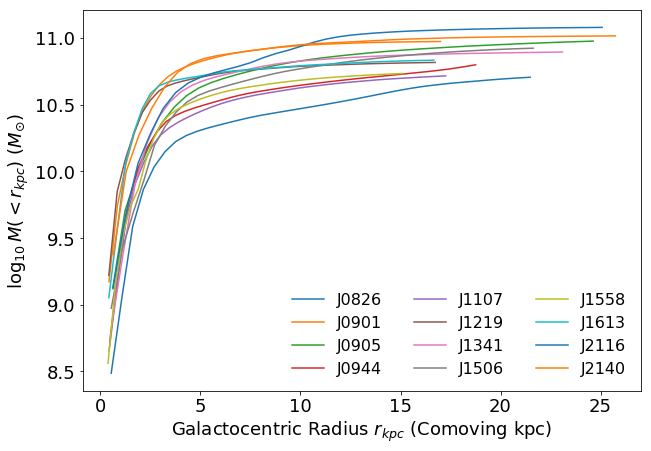

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
for igal in range(ngal):
    ax.plot(radkpc[igal, :], np.log10(np.cumsum(10**mstar[igal, :])), label=galaxy[igal])
ax.legend(loc='lower right', fontsize=16, ncol=3, frameon=False)
ax.set_xlabel(r'Galactocentric Radius $r_{kpc}$ (Comoving kpc)')
ax.set_ylabel(r'$\log_{10}\, M(<r_{kpc})\ (M_{\odot})$')

(6, 9.6)

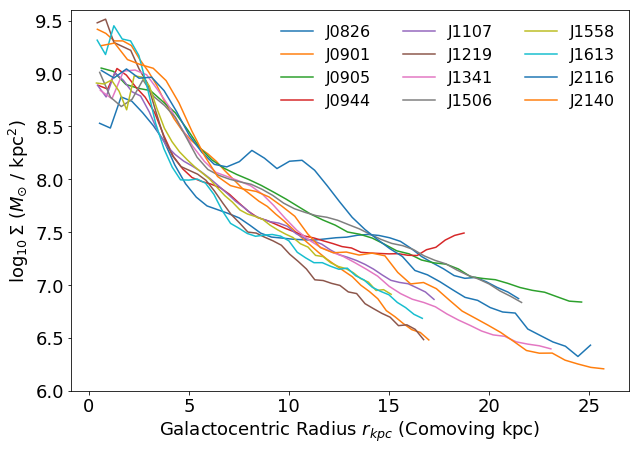

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))
for igal in range(ngal):
    ax.plot(radkpc[igal, :], sigma[igal, :], label=galaxy[igal])
ax.legend(loc='upper right', fontsize=16, ncol=3, frameon=False)
ax.set_xlabel(r'Galactocentric Radius $r_{kpc}$ (Comoving kpc)')
ax.set_ylabel(r'$\log_{10}\, \Sigma\ (M_{\odot}\ /\ {\rm kpc}^2)$')
ax.set_ylim(sigmarange)